<a href="https://colab.research.google.com/github/andrea-mar/MSci-Project/blob/main/subreddits_text_classification_roberta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

code reference: https://www.youtube.com/watch?v=vNKIg8rXK6w&t=1492s&ab_channel=rupertai

In [1]:
!nvidia-smi

Tue Oct  3 10:15:26 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from google.colab import drive

In [3]:
drive.mount('/content/drive', force_remount=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
train_data_path = '/content/drive/MyDrive/MS_DS_NLP_project/asd_subs_data_annotated/train_data.csv'
test_data_path = '/content/drive/MyDrive/MS_DS_NLP_project/asd_subs_data_annotated/test_data.csv'

In [5]:
train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

In [6]:
train_data.head(3)

,Unnamed: 0,text,Other,ASD
0,116,womenonthespectrum womenonthespectrum A commun...,0,1
1,293,The Owl House The Owl House A subreddit for th...,1,0
2,452,Autism Speaks Sucks Autism Speaks Sucks A comm...,0,1


In [7]:
# dataset is relatively ballanced
train_data['ASD'].value_counts()

1    90
0    78
Name: ASD, dtype: int64

In [8]:
len(train_data)

168

In [9]:
test_data.head(3)

,Unnamed: 0,text,Other,ASD
0,231,Gamingcirclejerk Gaming Circlejerk Don Cheadle...,1,0
1,243,ASDpeersupport ASD Peer Support Peer based sup...,0,1
2,392,selfharm A Subreddit for Self Harmers A subred...,1,0


In [10]:
# dataset is relatively balanced
test_data['ASD'].value_counts()

1    23
0    19
Name: ASD, dtype: int64

DEEP LEARNING LLMs - RoBERTa-large huggingface

In [11]:
%%capture
%pip install transformers
%pip install pytorch-lightning

Pipeline

model to fine tune : RoBERTa

original article : https://arxiv.org/abs/1907.11692

huggingface: https://huggingface.co/roberta-base

roberta-base is case sensitive
The datasets have no stop words (droped in the data cleaning stage) - even if there is a loss of useful context in the case of RoBERTa, it was done with a perspective of having a maximum of important words within the limit of the RoBERTa maximum sequence length, which is 512 tokens. (same as this article https://hal.science/hal-03725602)

<Axes: >

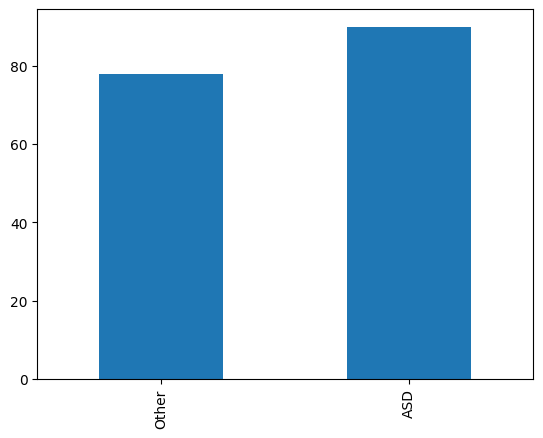

In [12]:
attributes = ['Other', 'ASD']
train_data[attributes].sum().plot.bar()

<Axes: >

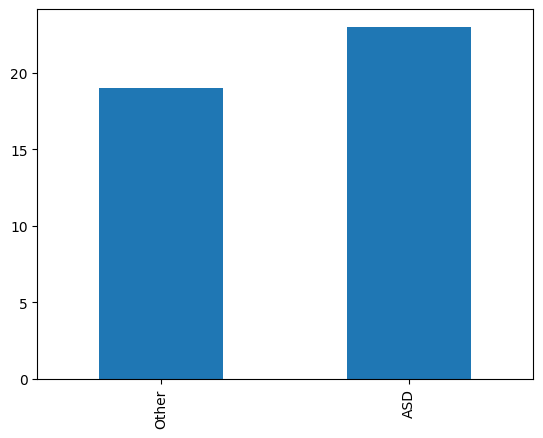

In [13]:
test_data[attributes].sum().plot.bar()

In [14]:
import torch.nn.functional as F
import torch
from torch.utils.data import Dataset
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification, RobertaForSequenceClassification, RobertaTokenizer

from sklearn.model_selection import train_test_split

In [15]:
# create a pytorch Dataset object containing tokenized and vectorized data
class Suberddits_Dataset(Dataset):
  np.random.seed(7)

  def __init__(self, data, tokenizer, attributes, max_token_len: int=512):
    self.data = data # dataframe (pandas)
    self.tokenizer = tokenizer
    self.attributes = attributes # class labels : ASD and Other
    self.max_token_len = max_token_len # 512 is the max RoBERTa accepts (see above)

  def __len__(self):
    return(len(self.data))


  def __getitem__(self, index):
    item = self.data.iloc[index] # get the item in the df at the given index
    text = str(item.text) # get the text for that row
    attr = torch.FloatTensor(item[self.attributes]) # get the values for ASD and Other cols in a tensor format
    # tokenize the text (as PyTorch tensors)
    tokens = self.tokenizer.encode_plus(text,
                                        return_tensors='pt', # return pytorch tensors
                                        truncation=True, # truncate the longer text
                                        max_length=self.max_token_len, # truncate the text to a max length of 512
                                        padding='max_length', # apply a padding to all text that is shorter that the max length (512)
                                        return_attention_mask=True)
    return {
        'input_ids': tokens.input_ids.flatten(),
        'attention_mask': tokens.attention_mask.flatten(),
        'labels': attr
        }


In [16]:
model_name = 'distilroberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [17]:
attributes = ['Other', 'ASD']
train_dataset = Suberddits_Dataset(train_data, tokenizer, attributes)
test_dataset = Suberddits_Dataset(test_data, tokenizer, attributes)

In [18]:
# what the item (text representation  and labels) looks like as PyTorch tensors
train_dataset.__getitem__(30)

{'input_ids': tensor([    0, 25683,   293, 20207,   293,     5,  1461,   187,  2266, 20207,
           293,    83,   169,     9,  9072,  4106,   335,   145,  1373,   660,
          7510,     9,    10,  2040,    50,   467,     9,  3650,    14,   189,
            28,  1687,     7,    28,  1595,    31,    65,  1736,     7,   277,
            30,   295,  1657,   225, 15557,   839,   941, 40059,   475, 43237,
            21,   259, 14826,     7, 20207,   293,  2573, 12555,    30,  1717,
          1577,  1178,   274,   134,  4629,  1178,  1577,  8515,     9,    10,
         25426, 26012, 32148,    10,   169,     9,  9072,  4106,   335,   145,
          1373,    41,  7510,     9,    10,  2040,    50,   467,     9,  3650,
            14,   189,    28,  1687,     7,    28,  1595,    31,    65,  1736,
             7,   277,    30,   295,  1657,   225, 15557,   839,   941, 40059,
          3401,  1591, 38451,  3629,  6114,     5,   235,     7,  3438,   143,
           618,    13,   143,  1219, 20

In [19]:
len(train_dataset), len(test_dataset)

(168, 42)

In [20]:
train_dataset.data.head(3)

,Unnamed: 0,text,Other,ASD
0,116,womenonthespectrum womenonthespectrum A commun...,0,1
1,293,The Owl House The Owl House A subreddit for th...,1,0
2,452,Autism Speaks Sucks Autism Speaks Sucks A comm...,0,1


In [21]:
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold

In [23]:
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
from pytorch_lightning import LightningDataModule
from typing import Optional

class Suberddits_Data_Module(LightningDataModule):
    def __init__(
        self,
        train_df,
        test_df,
        attributes,
        model_name="roberta-base",  # default model name if not provided
        k: int = 1,  # fold number
        num_splits: int = 10,
        split_seed = 7, # split the folds consistently the same each time code runs
        batch_size: int = 32,
        num_workers: int = 4,
        pin_memory: bool = False,
    ):
        super().__init__()

        # save hyperparameters ( this allows use of self.hparams.<hparam>)
        self.save_hyperparameters()
        self.train_df = train_df
        self.test_df = test_df
        self.attributes = attributes

        # initialize the tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(self.hparams.model_name)

        # data transformations
        self.transforms = None

        # Initialize datasets as None
        self.data_train = None
        self.data_val = None
        self.data_test = None

    def setup(self, stage=None):
        if not self.data_train and not self.data_val:
            # split the training data into k folds for training and validation
            kf = KFold(n_splits=self.hparams.num_splits, shuffle=True, random_state=self.hparams.split_seed)
            all_splits = [k for k in kf.split(self.train_df)]
            train_indexes, val_indexes = all_splits[self.hparams.k]
            train_indexes, val_indexes = train_indexes.tolist(), val_indexes.tolist()

            # create training and validation datasets
            self.data_train = Suberddits_Dataset(self.train_df.iloc[train_indexes], self.tokenizer, self.attributes)
            self.data_val = Suberddits_Dataset(self.train_df.iloc[val_indexes], self.tokenizer, self.attributes)

        if stage == 'predict':
            self.data_test = Suberddits_Dataset(self.test_df, self.tokenizer, self.attributes)

    def train_dataloader(self):
        return DataLoader(
            dataset=self.data_train,
            batch_size=self.hparams.batch_size,
            num_workers=self.hparams.num_workers,
            pin_memory=self.hparams.pin_memory,
            shuffle=True,
        )

    def val_dataloader(self):
        return DataLoader(
            dataset=self.data_val,
            batch_size=self.hparams.batch_size,
            num_workers=self.hparams.num_workers,
            pin_memory=self.hparams.pin_memory,
        )

    def predict_dataloader(self):
        return DataLoader(
            dataset=self.data_test,
            batch_size=self.hparams.batch_size,
            num_workers=self.hparams.num_workers,
            pin_memory=self.hparams.pin_memory,
        )

In [24]:
train_module = Suberddits_Data_Module(train_data, test_data, attributes)

In [25]:
train_module.setup()

In [26]:
dl = train_module.train_dataloader()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [27]:
len(dl)

5

Model

In [28]:
from transformers import AutoModel, AdamW, get_cosine_schedule_with_warmup
import torch.nn as nn
import math
from torchmetrics.functional.classification import auroc
import torch.nn.functional as F

In [29]:
class Subreddits_Classifier(pl.LightningModule):
  def __init__(self, config: dict):
    super().__init__()
    self.config = config
    self.pretrained_model = AutoModel.from_pretrained(config['model_name'], return_dict=True)
    self.hidden = nn.Linear(self.pretrained_model.config.hidden_size, self.pretrained_model.config.hidden_size)
    self.classifier = nn.Linear(self.pretrained_model.config.hidden_size, self.config['n_labels'])
    torch.nn.init.xavier_uniform(self.hidden.weight)
    torch.nn.init.xavier_uniform(self.classifier.weight)
    self.loss_function = nn.BCEWithLogitsLoss(reduction='mean')
    self.dropout = nn.Dropout()


  def forward(self, input_ids, attention_mask, labels=None):
    # distiled roberta model
    output = self.pretrained_model(input_ids=input_ids, attention_mask=attention_mask)
    pooled_output = torch.mean(output.last_hidden_state, 1)
    # nn classification layers
    pooled_output = self.hidden(pooled_output)
    pooled_output = self.dropout(pooled_output)
    pooled_output = F.relu(pooled_output)
    logits = self.classifier(pooled_output)
    # compute the loss
    loss = 0
    if labels is not None:
      loss = self.loss_function(logits.view(-1, self.config['n_labels']), labels.view(-1, self.config['n_labels']))
    return loss, logits

  def training_step(self, batch, batch_index):
    loss, logits = self(**batch)
    self.log('train_loss', loss, prog_bar=True, logger=True)
    return {'loss': loss, 'predictions': logits, 'labels': batch['labels']}

  def validation_step(self, batch, batch_index):
    loss, logits = self(**batch)
    self.log('validation loss', loss, prog_bar=True, logger=True)
    return {'val_loss': loss, 'predictions': logits, 'labels': batch['labels']}

  def predict_step(self, batch, batch_index):
    _, logits = self(**batch)
    return logits

  def configure_optimizers(self):
    optimizer = AdamW(self.parameters(), lr=self.config['lr'], weight_decay=self.config['w_decay'])
    total_steps = self.config['train_size'] / self.config['batch_size']
    warmup_steps = math.floor(total_steps * self.config['warmup'])
    scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps)
    return [optimizer], [scheduler]

Train

In [30]:
config = {
    'model_name': 'distilroberta-base',
    'n_labels': len(attributes),
    'batch_size': 14,
    'lr': 1.5e-6,
    'warmup': 0.2,
    'train_size': len(train_module.train_dataloader()),
    'w_decay': 0.001,
    'n_epoch': 100
}

In [31]:
np.random.seed(7)
model = Subreddits_Classifier(config)

<ipython-input-29-23c79f93be51>:8: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.hidden.weight)
<ipython-input-29-23c79f93be51>:9: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.classifier.weight)


In [32]:
idx = 0
input_ids = train_dataset.__getitem__(idx)['input_ids']
att_mask = train_dataset.__getitem__(idx)['attention_mask']
labels = train_dataset.__getitem__(idx)['labels']

In [33]:
loss, output = model(input_ids.unsqueeze(dim=0), att_mask.unsqueeze(dim=0), labels.unsqueeze(dim=0))

In [34]:
loss, output

(tensor(0.6657, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 tensor([[-0.1752, -0.0569]], grad_fn=<AddmmBackward0>))

Train

In [35]:
np.random.seed(7)
# train module
train_module = Suberddits_Data_Module(train_data, test_data, attributes, batch_size=config['batch_size'])
train_module.setup()

# model
model = Subreddits_Classifier(config)

# train
trainer = pl.Trainer(max_epochs=config['n_epoch'], num_sanity_val_steps=2)
trainer.fit(model, train_module)

<ipython-input-29-23c79f93be51>:8: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.hidden.weight)
<ipython-input-29-23c79f93be51>:9: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.classifier.weight)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or s

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (11) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


In [48]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [47]:
%tensorboard --logdir '/content/lightning_logs/version_0'

<IPython.core.display.Javascript object>

In [38]:
!ls -l

total 12
drwx------ 5 root root 4096 Oct  3 10:13 drive
drwxr-xr-x 3 root root 4096 Oct  3 10:16 lightning_logs
drwxr-xr-x 1 root root 4096 Sep 29 13:23 sample_data


In [39]:
!lsof -i :6006


COMMAND     PID USER   FD   TYPE DEVICE SIZE/OFF NODE NAME
tensorboa 11418 root   14u  IPv4 662922      0t0  TCP localhost:6006 (LISTEN)


In [40]:
from tensorboard import notebook
notebook.list()

Known TensorBoard instances:
  - port 6006: logdir /content/lightning_logs/version_2 (started 0:00:00 ago; pid 11418)


In [41]:
notebook.display(port=6006, height=500)

Selecting TensorBoard with logdir /content/lightning_logs/version_2 (started 0:00:00 ago; port 6006, pid 11418).


<IPython.core.display.Javascript object>

In [49]:
!tensorboard dev upload \
  --logdir '/content/lightning_logs/version_0' \
  --name 'Roberta finetuned' \
  --description 'Roberta finetuned to ASD subreddits data' \
  --one_shot

2023-10-03 10:55:36.673375: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

/content/lightning_logs/version_0

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

To sign in with the TensorBoard uploader:

1. On your computer or phone, visit:

   https://www.google.com/device

2. Sign in with your Google account, then enter:

   SDXG-SRYL



New experiment created. View your TensorBoard at: https://tens

Predict with model

In [118]:
# method to convert list of text into predictions for each text
def classify_raw_text(model, dm):
  predictions = trainer.predict(model, dm)
  flatten_predictions = np.stack([torch.sigmoid(torch.Tensor(p)) for batch in predictions for p in batch])
  return flatten_predictions


In [119]:
predictions = classify_raw_text(model, train_module)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Predicting: 0it [00:00, ?it/s]

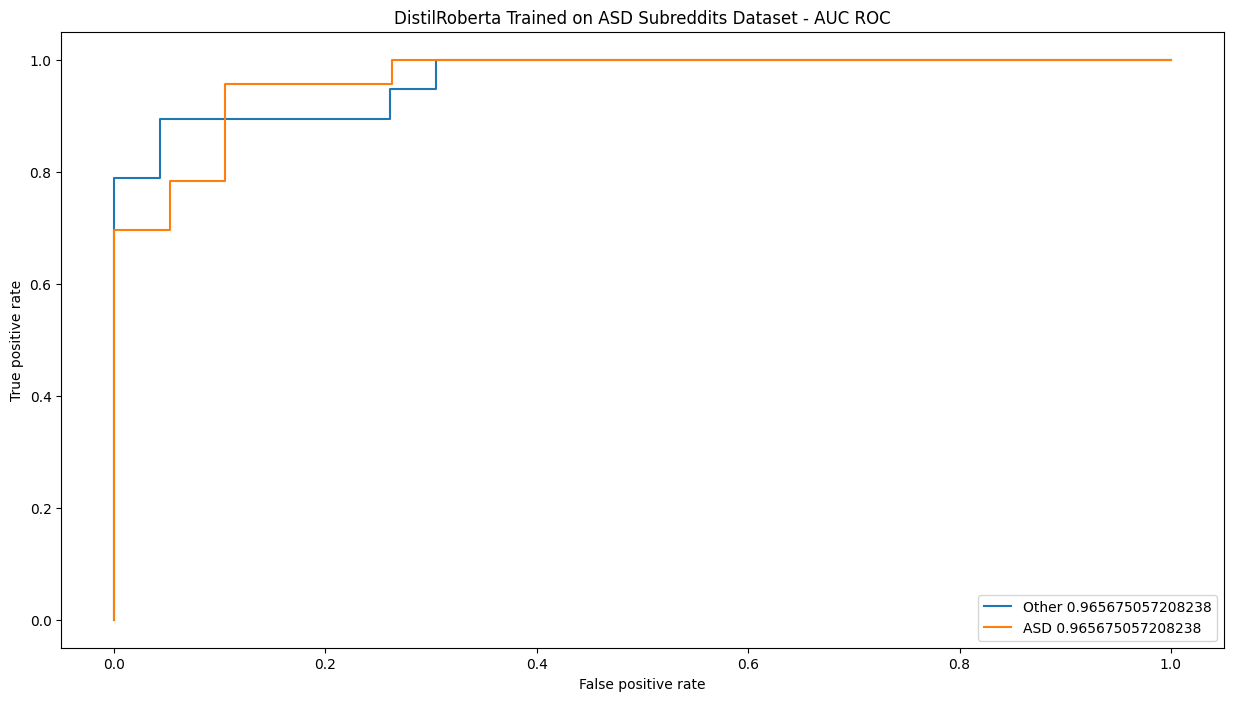

In [120]:
test_data_labels = np.array(test_data[attributes])

from sklearn import metrics

plt.figure(figsize=(15,8))
for i, attribute in enumerate(attributes):
  fpr, tpr, _ = metrics.roc_curve(
      test_data_labels[:,i].astype(int), predictions[:,i]
  )
  auc = metrics.roc_auc_score(
      test_data_labels[:,i].astype(int), predictions[:,i]
  )
  plt.plot(fpr, tpr, label=f'{attribute} {auc}')
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.legend(loc='lower right')
  plt.title('DistilRoberta Trained on ASD Subreddits Dataset - AUC ROC')

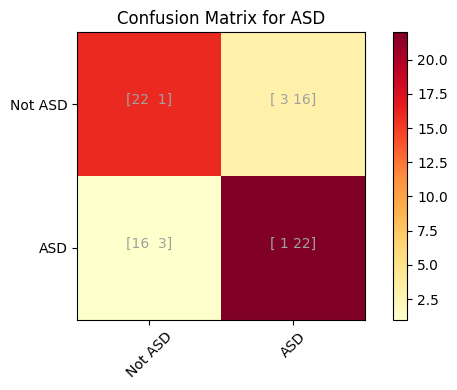

In [127]:
from sklearn.metrics import multilabel_confusion_matrix

# change predictions to binary labels (0 or 1)
binary_predictions = predictions.round()
conf_mtrx = multilabel_confusion_matrix(test_data_labels, binary_predictions)

# class labels
class_labels = ['Not ' + attribute, attribute]

# plot the confusion matrix
plt.figure(figsize=(6, 4))
plt.imshow(conf_mtrx[1], interpolation='nearest', cmap=plt.cm.YlOrRd)
plt.title(f'Confusion Matrix for {attributes[1]}')
plt.colorbar()

tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)

for i in range(2):
    for j in range(2):
      text_color = '#a1a1a1'
      plt.text(j, i, str(conf_mtrx[i][j]), horizontalalignment="center", color=text_color)

plt.tight_layout()
plt.show()


In [128]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# round predictions to convert probabilities to binary values (0 or 1)
rounded_predictions = predictions.round()

# accuracy score
accuracy = accuracy_score(test_data_labels, rounded_predictions)

# precision, recall, and F1 score
precisions = precision_score(test_data_labels, rounded_predictions, average='weighted')
recalls = recall_score(test_data_labels, rounded_predictions, average='weighted')
f1_scores = f1_score(test_data_labels, rounded_predictions, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precisions:.4f}")
print(f"Recall: {recalls:.4f}")
print(f"F1 Score: {f1_scores:.4f}")


Accuracy: 0.9048
Precision: 0.9077
Recall: 0.9048
F1 Score: 0.9041
